# Prediction of Loan Quality

### Import Libraries

First, we will list out and inport relevant libraries for this data science project.

In [1]:
# For reading data and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
# interactive visualization
import plotly.express as px
import matplotlib as plt
# For Clustering
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import PowerTransformer
# For Exploratory Data Analysis / Descriptive Data Analytics
import sweetviz as sv
import dtale
# For evaluation Clustering
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import shap
# For Machine Learning Classification
from sklearn.model_selection import train_test_split
# Accuracy Metrics
import joblib

c:\Users\PC\anaconda3\envs\python_work\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Data

next I will import data, for this project I will use only loan and underwriting data to see the loan risk. and to see if underwriting variables have correlation with how likely the loan been approved.

In [2]:
# import loan data
loan_data = pd.read_csv("C:/Users/PC/Downloads/DS Assessment/data/data/loan.csv")
# import underwriting data
underwriting_data = pd.read_csv("C:/Users/PC/Downloads/DS Assessment/data/data/clarity_underwriting_variables.csv")

Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.


### Descriptive Data Analysis

using 2 profiling packages, dtale and sweetviz see the relationship between variables

In [3]:

# Create a report
report = sv.analyze(loan_data)

# Display the report
report.show_html('loan_data.html')  # Save report to HTML file

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report loan_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


using sweet viz to visualize profiling for the loan data, we can see that this variables have some correlation with approved loan status:

nPaidOff                            0.27

loanAmount                          0.11

originallyScheduledPaymentAmount    0.10

leadCost                            0.09

apr                                 0.05

### Data Cleaning

after that, we will clean the data by only takes the one have Clear Fraud ID. this is because we will map it with clearfraudscore from underwriting variables data. so I will be left with loan application that have clearfraudscore value.

In [4]:
# Separate data based on 'hasCF' values
hasCF_0 = loan_data[loan_data['hasCF'] == 0]
hasCF_1 = loan_data[loan_data['hasCF'] == 1]

In [5]:
# 
# Add clearfraudscore to loan dataset using clearfraudid from both loan dataset and clarity fraud variables dataset.
# 

# standardized the column name, so that to merge datasets become easier
loan_data_hasCF_1 = hasCF_1.rename(columns={'clarityFraudId': 'underwritingid'})
selected_columns = ['clearfraudscore','underwritingid'] 

# Selecting specific columns from underwriting_data
selected_underwriting = underwriting_data[selected_columns]

# Merge loan_data with selected columns from underwriting_data based on 'underwritingId' column
merged_loan_data = loan_data_hasCF_1.merge(selected_underwriting, on='underwritingid', how='inner')
merged_loan_data = merged_loan_data.drop(columns='hasCF')

In [6]:
sv.analyze(merged_loan_data).show_html("merged_loan_data.html")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report merged_loan_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


we now have profiling for merged_loan data where I have merge loan data with underwriting data using clarityFraudId column and underwriting_id from both dataset respectively to get clearfraudscore.

#### Exploratory Data Analysis

Let's see how the data looks like for every states in US.

In [7]:
# Create a pivot table to count Loan by State
loan_application_counts = loan_data['state'].value_counts().reset_index()
loan_application_counts.columns = ['State', 'Application Count']

# Create an interactive heatmap using Plotly Express
fig = px.choropleth(locations=loan_application_counts['State'], locationmode='USA-states', 
                    color=loan_application_counts['Application Count'], 
                    scope="usa", 
                    title='Loan Application Count by States',
                    labels={'color': 'Application Count'},
                    color_continuous_scale='YlGnBu')

fig.update_layout(coloraxis_colorbar=dict(title='Loan Count'),
                  geo=dict(bgcolor='rgba(0,0,0,0)',
                           lakecolor='rgba(0,0,0,0)'))

# Display the interactive heatmap
fig.show()

We get to see that most of the loan application is people from OHIO with 90.496k people. Meanwhile the least loan application is from MARYLAND and NEW YORK with both at 3 loan application. Looks like the bank customer based is mostly at OHIO. Let's see the demographic for approved loan.

In [8]:
approved_loan = merged_loan_data[merged_loan_data['approved']== True]
approved_loan = approved_loan.dropna(subset=['clearfraudscore'])
approved_loan.head(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,underwritingid,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,879.0
1,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,2017-03-01T16:15:13.016000,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,658.0
2,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,True,2017-01-31T18:00:14.520000,2.0,True,1,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,835.0
3,LL-I-17491287,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-02-21T17:20:23.671000,True,2017-02-21T17:45:11.088000,3.0,True,1,Paid Off Loan,1250.0,3112.16,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,835.0
4,LL-I-15679301,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-18T01:16:24.941000,True,2017-01-18T01:30:16.712000,1.0,True,1,Paid Off Loan,500.0,1292.09,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,835.0


In [9]:
# Create a pivot table to count approved loan applications by state
approved_count = approved_loan['state'].value_counts().reset_index()
approved_count.columns = ['State', 'ApprovedCount']

# Create an interactive heatmap using Plotly Express
fig = px.choropleth(locations=approved_count['State'], locationmode='USA-states', 
                    color=approved_count['ApprovedCount'], 
                    scope="usa", 
                    title='Approved Loan Application by State',
                    labels={'color': 'Approved Count'},
                    color_continuous_scale='YlGnBu')

fig.update_layout(coloraxis_colorbar=dict(title='Approved Count'),
                  geo=dict(bgcolor='rgba(0,0,0,0)',
                           lakecolor='rgba(0,0,0,0)'))

# Display the interactive heatmap
fig.show()

We see that nothing much change in term of loan application density based on states. OHIO still the most approved loan application amongs US with 5002 approved loan application.

Now let's see how much is the estimated revenue generated by the banks from loan product and see the different with how much loan given from the bank and how muchbank revenue.

In [10]:
# Calculate the sum of loanAmount and originallyScheduledPaymentAmount
sum_loan_amount = approved_loan['loanAmount'].sum()
sum_scheduled_payment_amount = approved_loan['originallyScheduledPaymentAmount'].sum()

# Calculate the percentage difference between the sums
percentage_difference = ((sum_scheduled_payment_amount - sum_loan_amount) / sum_loan_amount) * 100

# Display the calculated sums and percentage difference
print("Approved Loan:")
print(f"Sum of loanAmount: {sum_loan_amount}")
print(f"Sum of originallyScheduledPaymentAmount: {sum_scheduled_payment_amount}")
print(f"Difference between cumulative loanAmount & originallyScheduledPaymentAmount: {sum_scheduled_payment_amount - sum_loan_amount}")
print(f"Percentage Difference: {percentage_difference:.2f}%")

Approved Loan:
Sum of loanAmount: 21150093.0
Sum of originallyScheduledPaymentAmount: 58166145.185628
Difference between cumulative loanAmount & originallyScheduledPaymentAmount: 37016052.185628
Percentage Difference: 175.02%


In [11]:
data = {'Amount Type': ['loanAmount', 'originallyScheduledPaymentAmount'],
        'Sum Amount': [sum_loan_amount, sum_scheduled_payment_amount]}
df = pd.DataFrame(data)
# Plotting a bar chart using Plotly Express
fig = px.bar(df, x='Amount Type', y='Sum Amount',
             labels={'Sum Amount': 'Sum of Amount'},
             title='Comparison of Sum between loanAmount and originallyScheduledPaymentAmount for Approved Loan Applications')
fig.show()

There are stark different between loanAmount and originalllyScheduledPaymentAmount. this is reasonable as bank got APR to get the profit from. the contrast between loan given from the bank and money received is 37 Millions USD.

In [12]:
sv.analyze(approved_loan).show_html("approved_loan.html")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report approved_loan.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Above is the profilling for the approved loan. We can extract much information from this such as Correlation analysis and to see the outlier from each column.

Now let's see the visualization for rejected loan application ie approved column value False.

In [13]:
rejected_loan = merged_loan_data[merged_loan_data['approved']==False]
rejected_loan.head(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,underwritingid,clearfraudscore
19,LL-I-08481484,feb7fad96c04b2eae8caadbca52c8cf6,I,490.0,2016-04-06T23:56:04.785000,False,NaN,1.0,False,0,Rejected,1500.0,4102.01,MO,bvMandatory,6,NaN,57067671e4b06ef47d14d67d,736.0
20,LL-I-09039899,feb7fad96c04b2eae8caadbca52c8cf6,S,390.0,2016-05-03T15:29:51.080000,False,NaN,2.0,False,0,Withdrawn Application,2000.0,4451.24,MO,organic,0,NaN,57067671e4b06ef47d14d67d,736.0
21,LL-I-09039908,feb7fad96c04b2eae8caadbca52c8cf6,M,390.0,2016-05-03T15:36:59.625000,False,NaN,2.0,False,0,Withdrawn Application,2000.0,4643.83,MO,organic,0,NaN,57067671e4b06ef47d14d67d,736.0
22,LL-I-09042657,feb7fad96c04b2eae8caadbca52c8cf6,B,390.0,2016-05-05T16:12:57.746000,False,NaN,2.0,False,0,Withdrawn Application,2500.0,5810.50,MO,organic,0,NaN,57067671e4b06ef47d14d67d,736.0
24,LL-I-09042625,feb7fad96c04b2eae8caadbca52c8cf6,B,390.0,2016-05-05T15:55:31.285000,False,NaN,2.0,False,0,Withdrawn Application,2500.0,5810.50,MO,organic,0,NaN,57067671e4b06ef47d14d67d,736.0


In [14]:
# Create a pivot table to count rejected loan applications by state
rejected_counts = rejected_loan['state'].value_counts().reset_index()
rejected_counts.columns = ['State', 'PaidOffLoanCount']

# Create an interactive heatmap using Plotly Express
fig = px.choropleth(locations=rejected_counts['State'], locationmode='USA-states', 
                    color=rejected_counts['PaidOffLoanCount'], 
                    scope="usa", 
                    title='Paid Off Loans by State',
                    labels={'color': 'PaidOffLoanCount'},
                    color_continuous_scale='YlGnBu')

fig.update_layout(coloraxis_colorbar=dict(title='Paid Off Count'),
                  geo=dict(bgcolor='rgba(0,0,0,0)',
                           lakecolor='rgba(0,0,0,0)'))

# Display the interactive heatmap
fig.show()

We can see that OHIO is still the most state that got rejected their loan application with 758. this is not surprising as they also have the most loan application out there with more than 90k loan application. 

Now let's see the profiling for the rejected loan.

In [15]:
sv.analyze(rejected_loan).show_html("rejected_loan.html")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report rejected_loan.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Below we got the cumulative different for laonAmount and originallyScheduledPaymentAmount for rejected loan. why do we need to know this? This is because we caould assess the loan risk, indicate that riskier borrowing or repayment profile range.

In [16]:
# Calculate the sum of loanAmount and originallyScheduledPaymentAmount
sum_rejected_amount = rejected_loan['loanAmount'].sum()
sum_rejected_scheduled_payment_amount = rejected_loan['originallyScheduledPaymentAmount'].sum()

# Calculate the percentage difference between the sums
percentage_difference_r = ((sum_rejected_scheduled_payment_amount - sum_rejected_amount) / sum_rejected_amount) * 100

# Display the calculated sums and percentage difference
print("Rejected:")
print(f"Sum of loanAmount: {sum_rejected_amount}")
print(f"Sum of originallyScheduledPaymentAmount: {sum_rejected_scheduled_payment_amount}")
print(f"Difference between cumulative loanAmount & originallyScheduledPaymentAmount for PaidOff loan: {sum_rejected_scheduled_payment_amount - sum_rejected_amount}")
print(f"Percentage Difference paid off loan: {percentage_difference_r:.2f}%")

Rejected:
Sum of loanAmount: 2882864.75
Sum of originallyScheduledPaymentAmount: 7506444.85
Difference between cumulative loanAmount & originallyScheduledPaymentAmount for PaidOff loan: 4623580.1
Percentage Difference paid off loan: 160.38%


there are huge different between originallyScheduledpaymentAmount with loanAmount. this might be because of high APR. we will see in the next visualization.

In [17]:
data = {'Amount Type': ['loanAmount', 'originallyScheduledPaymentAmount'],
        'Sum Amount': [sum_rejected_amount, sum_rejected_scheduled_payment_amount]}
df = pd.DataFrame(data)
# Plotting a bar chart using Plotly Express
fig_p = px.bar(df, x='Amount Type', y='Sum Amount', 
             labels={'Sum Amount': 'Sum of Amount'},
             title='Comparison of Sum between loanAmount and originallyScheduledPaymentAmount for Rejected Application Loan')
fig_p.show()

Below is the box plot for APR from rejected laon application. we get to see that the highest APR is 681, while the median is 590. surprisingly, there are also laon that have 0 APR but still got rejected. wonder why is this. let's see on the next visualization.

In [18]:
fig = px.box(rejected_loan, y='apr', title='Rejected: Box Plot APR')

# Show the plot
fig.show()

In [19]:
fig = px.box(rejected_loan, y='clearfraudscore', title='Rejected Loan Application Loan: Box Plot clearfraudscore')

# Show the plot
fig.show()

based on Data dictionary, the higher the clearfraudscore, the less likely the borrower will go defaults. so there are some question as why the box plot above got clearfraudscore 953 at the highest points. maybe we need more investigation on this.

In [20]:
fig = px.box(rejected_loan, y='nPaidOff', title='Rejected Loan Application Loan: Box Plot nPaidOff')

# Show the plot
fig.show()

Now we see that from the box plot that most applicant got rejected because they dont have history of payback loan, most of them have 0 nPaidOff. this might give the loaner some insecurities if the borrower can pay back the money.

In [21]:
# Data for the donut chart
data = {
    'approved': [True, False],
    'Expected Revenue': [sum_rejected_scheduled_payment_amount, sum_scheduled_payment_amount]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting a donut chart using Plotly Express
fig_donut = px.pie(df, names='approved', values='Expected Revenue', hole=0.5,
             title='Comparison Sum Reejcted and Approved Application for Expected Revenue')
fig_donut.show()

While it is regrettable that bank cannot make more money, but seen from the donut graph above, its not that bad as rejected application will result in 11.4% of total possible revenue if whole loan is approved. but of course in term of big money, the 11% is actually hugh sum of money with more than 7 half Millions USD.

### Data Preparation

Now we will do some data preparation to prepare the data to do cluster analysis. the objective for the cluster is to group the good and bad loan ie risk of the loan, either it is a good risk loan or not.

In [22]:
#  find out which column have the null value
merged_loan_data.isnull().any()

loanId                               True
anon_ssn                            False
payFrequency                         True
apr                                  True
applicationDate                     False
originated                          False
originatedDate                       True
nPaidOff                             True
approved                            False
isFunded                            False
loanStatus                           True
loanAmount                           True
originallyScheduledPaymentAmount    False
state                                True
leadType                            False
leadCost                            False
fpStatus                             True
underwritingid                      False
clearfraudscore                      True
dtype: bool

In [23]:
print(merged_loan_data['fpStatus'].isnull().value_counts())
print(merged_loan_data['state'].isnull().value_counts())
print(merged_loan_data['loanAmount'].isnull().value_counts())
print(merged_loan_data['loanStatus'].isnull().value_counts())
print(merged_loan_data['nPaidOff'].isnull().value_counts())
print(merged_loan_data['payFrequency'].isnull().value_counts())
print(merged_loan_data['apr'].isnull().value_counts())
print(merged_loan_data['clearfraudscore'].isnull().value_counts())

fpStatus
False    32456
True      3878
Name: count, dtype: int64
state
False    36320
True        14
Name: count, dtype: int64
loanAmount
False    36317
True        17
Name: count, dtype: int64
loanStatus
False    36323
True        11
Name: count, dtype: int64
nPaidOff
False    36332
True         2
Name: count, dtype: int64
payFrequency
False    36230
True       104
Name: count, dtype: int64
apr
False    36317
True        17
Name: count, dtype: int64
clearfraudscore
False    36225
True       109
Name: count, dtype: int64


In [24]:
# Fill in null values with N/A for those categorical variables
merged_loan_data['fpStatus'].fillna('N/A', inplace=True)
merged_loan_data['loanStatus'].fillna('N/A', inplace=True)
merged_loan_data['payFrequency'].fillna('N/A', inplace=True)

In [25]:
# we will just drop the null values for those numerical value, we dont have any metrics to replace the null value with the possible value.
merged_loan_data = merged_loan_data.dropna(subset=['state', 'loanAmount', 'nPaidOff', 'apr', 'clearfraudscore'])

#### Clustering Analysis

I will be using KPrototypes algorithm to do the clustering. K-Prototypes is a lesser known sibling for K-means but offers an advantage of working with mixed data types. It measures distance between numerical features using Euclidean distance (like K-means) but also measure the distance between categorical features using the number of matching categories.

In [27]:
kprot_data = merged_loan_data.copy()
# Remove IDs and highly correlated columns
kprot_data = kprot_data.drop(columns=['applicationDate', 'originatedDate', 'underwritingid', 'anon_ssn', 'loanId', 'originated', 'fpStatus', 'loanStatus', 'isFunded', 'approved'], axis=1)

#Pre-processing
for c in kprot_data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = [0, 5, 6]

#Actual clustering
kproto = KPrototypes(n_clusters= 2, init='Cao', n_jobs = 5)
proto_clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(proto_clusters).value_counts()

0    22132
1    14060
Name: count, dtype: int64

Here we got that we have cluster 0 with more than 22 thousands value while cluster 1 is more than 14 thousands value. having our hypothesis earlier, where approved is the good risk loan, we will map it with 0.

##### Visualization for Clustering

we will see the visualization for this clustering and see hwo it looks like.

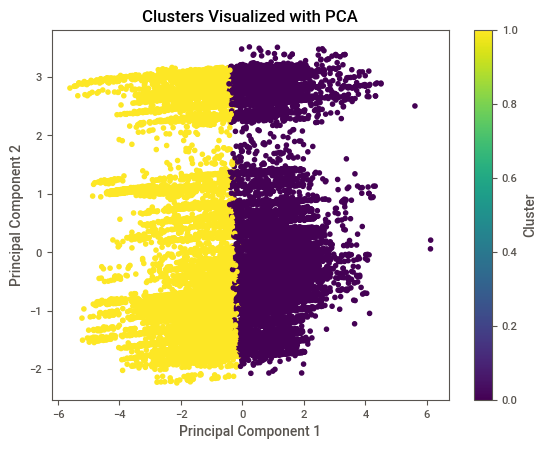

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# select numerical data
numerical = kprot_data.select_dtypes(exclude='object')

for c in kprot_data.columns:
    kprot_data.loc[:, c] = np.array(kprot_data[c]).reshape(-1, 1)
    
##preprocessing categorical
categorical = kprot_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

# Concatenate numerical and preprocessed categorical columns
processed_data = pd.concat([numerical, categorical], axis=1)

# Assuming kprot_data has already been preprocessed (numerical columns transformed)
pca = PCA(n_components=2)  # You can set n_components=3 for 3D visualization
reduced_data = pca.fit_transform(processed_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=proto_clusters, cmap='viridis')
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

we can see that it have a good clustering classes as the color is distinguishable from each other. they equally distributed with clear boundries.

#### Accuracy Metrics for Clustering

we will try to see the accuracy metrics for the clustering. Another comparison that I’m going to do is by treating the clusters as labels and building a classification model on top. If the clusters are of high quality, the classification model will be able to predict them with high accuracy. At the same time, the models should use a variety of features to ensure that the clusters are not too simplistic. Overall, I’ll check the following attributes:

Distinctivness of clusters by cross-validated F1 score
Informativness of clusters by SHAP feature importances
I will use LightGBM as my classifier because it can use categorical features and you can easily get the SHAP values for the trained models.

In [29]:
lgbm_data = processed_data.copy()
clf_kp = lgb.LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, proto_clusters, scoring='f1_weighted')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 11248, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 28953, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388492 -> initscore=-0.453657
[LightGBM] [Info] Start training from score -0.453657
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 11248, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

In [30]:
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.9930377880189273


the score of 0.99 is high enough to conclude that K-Prototypes clusters are meaningful and distinguishable. To determine if the clusters are also distinct and informative, we need to look at SHAP values for this classifier.

In [31]:
merged_loan_data['Cluster'] = proto_clusters
merged_loan_data.tail(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,underwritingid,clearfraudscore,Cluster
36329,LL-I-17508871,f0b666fdd1b46c58297b3828b61047ad,M,180.2,2017-02-21T20:29:57.538000,True,2017-02-21T20:45:06.563000,0.0,True,1,Returned Item,500.0,794.60,CO,lead,25,Rejected,58aca342e4b0bf804c0e82db,695.0,0
36330,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14T19:43:08.685000,True,2017-01-14T20:00:10.426000,0.0,True,1,Paid Off Loan,375.0,1042.40,AL,lead,25,Checked,587a7f49e4b08f2485d48358,700.0,0
36331,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22T01:10:50.110000,True,2016-06-22T21:46:54.359000,0.0,True,1,Paid Off Loan,400.0,664.12,WI,lead,40,Checked,5769e592e4b0ab6c50364d45,806.0,0
36332,LL-I-14178923,d9a63e9e15b862fcaaf3653c52e1f16c,B,625.0,2016-12-30T15:49:39.785000,True,2016-12-30T16:00:12.500000,0.0,True,1,New Loan,600.0,1868.88,IN,lead,25,Checked,58668211e4b08f246e282356,769.0,1
36333,LL-I-13311312,043dd86c24c63c8968082fa3ad7a8911,W,645.0,2016-12-16T20:20:30.157000,True,2016-12-16T23:15:06.874000,0.0,True,1,Paid Off Loan,300.0,1034.38,CT,lead,6,Checked,5840ad86e4b0bb9d6980127f,827.0,0


I want to see the glimpe of comparison, either the cluster do good or not. i will also calculate the percentage where the value of approved and the cluster are the same.

In [32]:
comparison = merged_loan_data[['approved', 'Cluster']]
comparison.tail(5)

,approved,Cluster
36329,True,0
36330,True,0
36331,True,0
36332,True,1
36333,True,0


In [33]:
# Count the number of matched pairs (True, 1 or False, 0)
matched_pairs = ((comparison['approved'] == True) & (comparison['Cluster'] == 0)).sum() + ((comparison['approved'] == False) & (comparison['Cluster'] == 1)).sum()
matched_pairs

21543

In [34]:
percentage_same = (matched_pairs/len(merged_loan_data))*100
print(f"Percentage Cluster same as approved status: {percentage_same:.2f}%")

Percentage Cluster same as approved status: 59.52%


the percentage of the cluster same as the approved is **60%** if rounded.

The objective of this project is to predict the loan risk. 

for the sake of experimenting, I will have the hypothesis that the loan is considered good by the status loan has been approved.

##### Feature importance for Clustering

now we will see the feature importance for clustering, wher are the most improtance variables to determine the clustering class.

In [35]:
clf_kp.fit(lgbm_data, proto_clusters)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 14060, number of negative: 22132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 36192, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388484 -> initscore=-0.453691
[LightGBM] [Info] Start training from score -0.453691


LGBMClassifier(colsample_by_tree=0.8)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


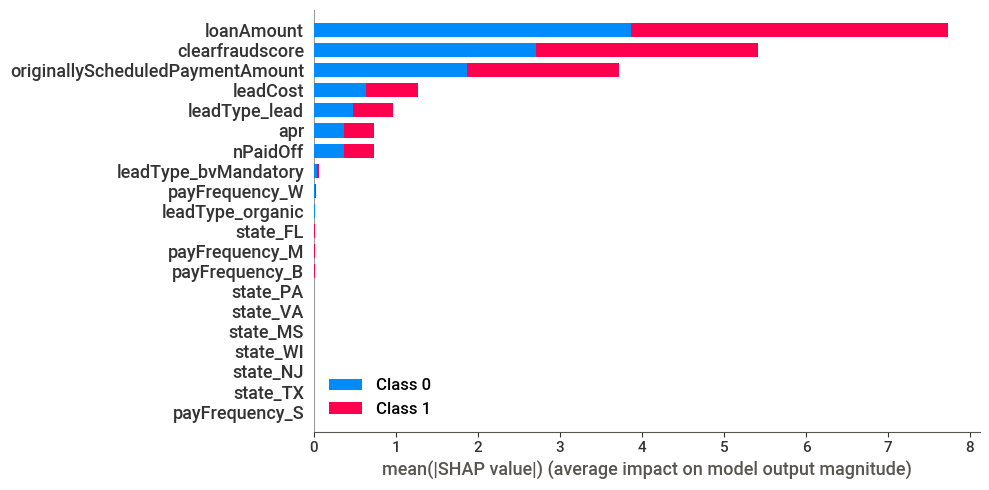

In [36]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(10, 5))

To classify the K-Prototypes clusters, LightGBM needs 8 features and 3 of them are quite important. Categorical features are the least important.

Overall, classifiers for the clustering methods have F1 score close to 1 which means that K-prototypes have produced clusters that are easily distinguishable. LightGBM uses 7 important features, and some of the categorical features quite important. This proves that the clusters produced by K-Prototypes are informative.

##### Save Data to data folder

In [37]:
# Save data
merged_loan_data.to_excel("C:\\Users\\PC\\OneDrive - Universiti Malaya\\Resume\\MoneyLion\\data(if any)\\merged_loan.xlsx", index=False)

#### Predict if the loan is good loan (ie low risk)

now that we know the good and bad loan, lets do some prediction for assessing either the loan is good or not for the loaner.

##### import data

In [38]:
# import master data
data = pd.read_excel("C:\\Users\\PC\\OneDrive - Universiti Malaya\\Resume\\MoneyLion\\data(if any)\\merged_loan.xlsx")

##### Data Cleaning

now we need to clean the data, remove unwanted columns and highly correlated column, because it will be bias for model development later.

In [39]:
# Remove IDs and Highly correlated columns
data = data.drop(['loanId', 'anon_ssn', 'applicationDate', 'originatedDate', 'underwritingid', 'fpStatus', 'loanStatus', 'isFunded', 'originated'], axis=1)

In [40]:
data = data.dropna()

##### Data Preprocessing

we will do some preprocessing so that the data ready to be trained. such as change the datatype for categorical variables from object to category, change the categorical variable to int as the LightGBM need the data in numeric, and as our target is a binary, we can just put it as bool datatype.

In [41]:
# Define input features and target variable
input_cols = ['payFrequency', 'apr',  'nPaidOff', 
              'loanAmount', 'originallyScheduledPaymentAmount', 
              'state', 'leadType', 'leadCost', 'clearfraudscore']
target_col = 'Cluster'
categorical_feature_names = ['payFrequency', 'state', 'leadType']

label_encoder = LabelEncoder()

for c in categorical_feature_names:
    data[c] = label_encoder.fit_transform(data[c])
    data[c] = data[c].astype('category')

data[target_col]= data[target_col].astype('bool')



##### Data Splitting

splitting the data with training, validating, and testing.

the training is 80%, validate is 20%, while testing is the last 5 rows fom the original dataset.

In [42]:
data_test = data.iloc[-5:]
data = data.iloc[5:]

X = data[input_cols]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Data Modelling

for data modelling/model development, im using the same algorithm as before, lightGBM as it can use categorical features and can easily get SHAP values for the trained model.

In [43]:
clf = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 11240, number of negative: 17629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 28869, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389345 -> initscore=-0.450066
[LightGBM] [Info] Start training from score -0.450066


LGBMClassifier(colsample_by_tree=0.8)

##### Feature Importance

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


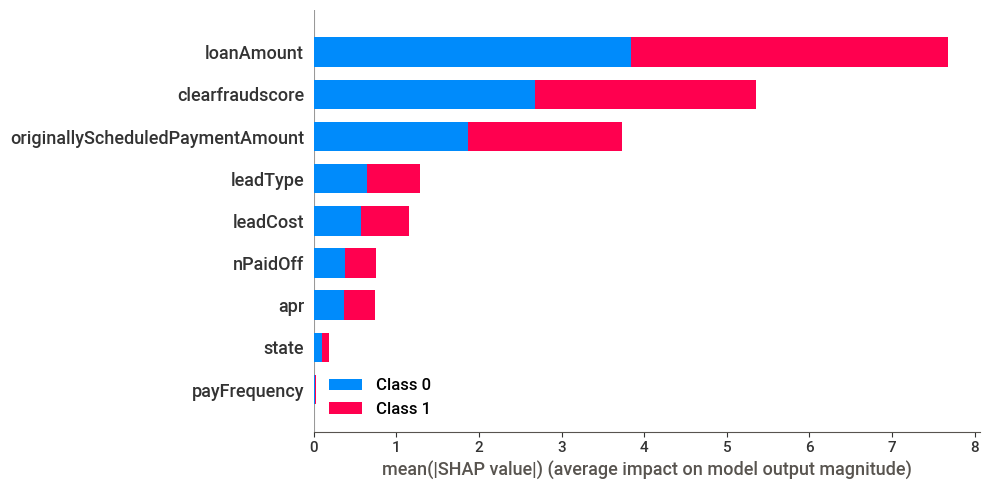

In [44]:
explainer_kp = shap.TreeExplainer(clf)
shap_values_kp = explainer_kp.shap_values(X_train)
shap.summary_plot(shap_values_kp, X_train, plot_type="bar", plot_size=(10, 5))

same as before, the loanAmount give the highest inportance to determine the good loan risk or bad loan risk.

##### Accuracy Metrics

now we will do accuracy metrics to knwo how well the trained model works.

In [45]:
cv_scores = cross_val_score(clf, X_test, y_test, scoring='f1_weighted')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 2253, number of negative: 3521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 5774, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390197 -> initscore=-0.446482
[LightGBM] [Info] Start training from score -0.446482
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 2253, number of negative: 3521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

In [46]:
print(np.mean(cv_scores))

0.9876716660486862


for the accuracy model, I using F1 score, and the trained model got **98%** accuracy score. Which shows that the model can easily predict the cluster classes.

##### Save model

In [47]:
filename = 'classification_model.pkl'
joblib.dump(clf, filename)

['classification_model.pkl']

##### Test the model with new untrained data

now we will be testing the model with new, unseen data that we slice earlier.

In [48]:
data_test_x = data_test.drop(columns=['approved', 'Cluster'])


In [49]:
data_test_y = data_test['Cluster']

In [50]:
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(data_test_x, data_test_y)
print(result)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
1.0


In [51]:
y_test_pred = clf.predict(data_test_x)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


In [52]:
concat = pd.DataFrame(y_test_pred, data_test_y, columns=['Predicted'])
concat

,Predicted
Cluster,
False,False
False,False
False,False
True,True
False,False


We get to see that the model correctly predict the 5 rows classes. 

in conclusion, I manage to build a prediction model for predicting good or bad loan risk based on input features during loan application.